In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
dataset ='https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset'

In [4]:
od.download(dataset)

Skipping, found downloaded files in "./new-plant-diseases-dataset" (use force=True to force download)


In [5]:
!pip install tensorflow

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
tdataset = tf.keras.preprocessing.image_dataset_from_directory(
    'new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 70295 files belonging to 38 classes.


2024-11-25 13:03:18.268282: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
vdataset= tf.keras.preprocessing.image_dataset_from_directory(
    'new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 17572 files belonging to 38 classes.


In [7]:
class_names = tdataset.class_names
len(class_names)

38

In [8]:
for image_batch, labels_batch in tdataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[12 33 33  5 29  2  6 29  5 17 11  8 33 29 29 26  3 32 31  8 22 28 22 29
 10 31 33 17  0 35 19 29]


2024-11-25 13:03:28.072205: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(tdataset)

In [11]:
len(val_ds)

219

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras import Sequential

resize_rescale = Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to 256x256
    Rescaling(1.0 / 255)  # Rescale pixel values to [0, 1]
])

In [21]:
from tensorflow.keras.layers import RandomFlip,RandomRotation
from tensorflow.keras import Sequential
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

In [22]:
height=256
width=256
depth=3
n_classes=38

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
base_dir='new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'

In [25]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
      # Use 20% of data for validation
)

In [26]:
IMAGE_SIZE=256
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

Found 70295 images belonging to 38 classes.


In [27]:
# Get the first batch of data from the generator
X_batch, y_batch = next(train_generator)

# Print the shapes
print(f"Shape of X (images): {X_batch.shape}")
print(f"Shape of y (labels): {y_batch.shape}")


Shape of X (images): (32, 256, 256, 3)
Shape of y (labels): (32, 38)


In [23]:
base_dir='new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [27]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
   validation_split=0.9# Use 20% of data for validation
)

In [28]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)

Found 15799 images belonging to 38 classes.


In [32]:
test_generator=data_gen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

Found 1773 images belonging to 38 classes.


In [33]:
from keras.models import Sequential
from keras.layers import BatchNormalization,Activation, Flatten, Dropout, Dense,MaxPooling2D,Conv2D
from tensorflow.keras import backend as K

In [34]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(38, activation='softmax'))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    62,980,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,009,510 (240.36 MB)

 Trainable params: 63,009,510 (240.36 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,  # Number of steps per epoch
    epochs=5,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE  # Validation steps
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1741s 792ms/step - accuracy: 0.6079 - loss: 1.5666 - val_accuracy: 0.8505 - val_loss: 0.4742
Epoch 2/5
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 27:05 740ms/step - accuracy: 0.9062 - loss: 0.6270

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-25 05:19:10.815952: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - accuracy: 0.9062 - loss: 0.6270 - val_accuracy: 0.8261 - val_loss: 0.6002
Epoch 3/5
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1791s 815ms/step - accuracy: 0.9195 - loss: 0.2521 - val_accuracy: 0.8776 - val_loss: 0.3962
Epoch 4/5
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1s 47us/step - accuracy: 0.9375 - loss: 0.1635 - val_accuracy: 0.8696 - val_loss: 0.4615
Epoch 5/5


2024-11-25 05:49:48.996787: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1802s 820ms/step - accuracy: 0.9668 - loss: 0.1039 - val_accuracy: 0.8988 - val_loss: 0.3758


In [38]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
493/493 ━━━━━━━━━━━━━━━━━━━━ 96s 194ms/step - accuracy: 0.8955 - loss: 0.3953
Validation Accuracy: 89.88%


In [41]:
print("Evaluating model...")
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"test Accuracy: {test_accuracy * 100:.2f}%")

Evaluating model...
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.8908 - loss: 0.3531
test Accuracy: 89.83%


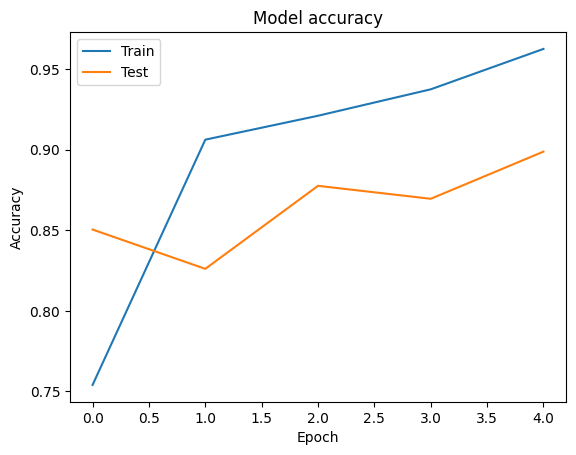

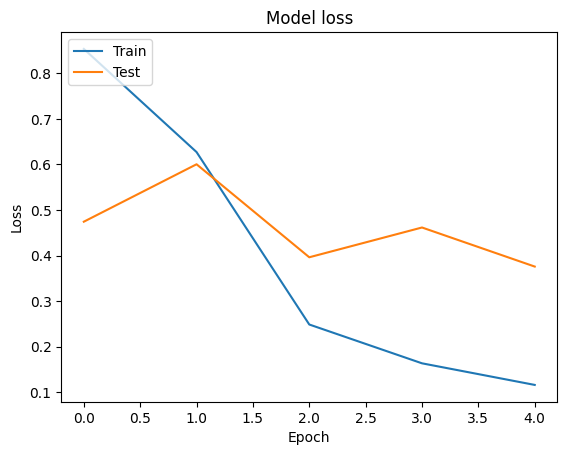

In [42]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
"""def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name"""

In [43]:
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [44]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [39]:
import json

In [40]:
json.dump(class_indices, open('class_indices.json', 'w'))

In [45]:
def load_and_preprocess_image(image, target_size=(256, 256)):
    """
    Preprocess an image for prediction. Accepts a PIL Image object or a numpy array.
    """
    # If the input is a PIL Image, convert it to a numpy array
    if isinstance(image, Image.Image):
        img = image.resize(target_size)  # Resize the image
        img_array = np.array(img)       # Convert to numpy array
    elif isinstance(image, np.ndarray):
        # If it's already a numpy array, resize it
        img = Image.fromarray(image)
        img = img.resize(target_size)
        img_array = np.array(img)
    else:
        raise ValueError("Input must be a PIL.Image or a numpy array.")
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.0
    return img_array

def predict_image_class(model, image, class_indices):
    """
    Predict the class of the given image using the provided model.
    """
    preprocessed_img = load_and_preprocess_image(image)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name



In [46]:
from PIL import Image
import numpy as np

# Example: Load an image from disk or another source
image = Image.open('new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot/0b8dabb7-5f1b-4fdc-b3fa-30b289707b90___JR_FrgE.S 3047_270deg.JPG')

# Example class indices mapping (replace with your actual mapping)

# Predict the class of the image
predicted_class_name = predict_image_class(model, image, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted Class Name: Apple___Black_rot


In [46]:
"""# Example Usage
image_path = '/content/test_apple_black_rot.JPG'
#image_path = '/content/test_blueberry_healthy.jpg'
#image_path = '/content/test_potato_early_blight.jpg'
predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)"""

'# Example Usage\nimage_path = \'/content/test_apple_black_rot.JPG\'\n#image_path = \'/content/test_blueberry_healthy.jpg\'\n#image_path = \'/content/test_potato_early_blight.jpg\'\npredicted_class_name = predict_image_class(model, image_path, class_indices)\n\n# Output the result\nprint("Predicted Class Name:", predicted_class_name)'

In [47]:
#model.save('drive/MyDrive/Youtube/trained_models/plant_disease_prediction_model.h5')

In [48]:
#model.save('plant_disease_prediction_model.h5')

In [ ]:
import pickle
with open('plant_disease_detection1.pickle','wb') as f:
    pickle.dump(model,f)

In [55]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [51]:
import os
os.makedirs("model", exist_ok=True)

In [57]:
import os

model_version = 1
save_path = f"model/{model_version}"

# Ensure the directory exists
os.makedirs("model", exist_ok=True)

# Use the export method to save the model in SavedModel format
model.export(save_path)


INFO:tensorflow:Assets written to: model/1/assets


INFO:tensorflow:Assets written to: model/1/assets


Saved artifact at 'model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  139675036734160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139672144544864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139672144556304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139672143351824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139672143358160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139672143359040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139672143363440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139672143357984: TensorSpec(shape=(), dtype=tf.resource, name=None)
